In [160]:
# Loading the required liabries.

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import pandas as pd
from pyspark.sql import SparkSession, DataFrameReader

import warnings
warnings.filterwarnings("ignore")
import plotly as py

py.offline.init_notebook_mode(connected = True)

from pyspark.sql import SparkSession, DataFrameReader
from enum import Enum


In [161]:
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("Netflix") \
    .getOrCreate()

In [162]:
CSV_DATA_PATH = './data/netflix_data.csv'

In [163]:
# df=pd.read_csv("./netflix_titles.csv")
df_reader = spark.read
global_df = df_reader.csv(CSV_DATA_PATH, header=True, inferSchema=True).toPandas()
global_df

,show_id,type,title,director,cast,country,date_added,release_year,rating,duration,listed_in,description
0,s1,Movie,Dick Johnson Is Dead,Kirsten Johnson,None,United States,"September 25, 2021",2020,PG-13,90 min,Documentaries,"As her father nears the end of his life, filmm..."
1,s2,TV Show,Blood & Water,None,"Ama Qamata, Khosi Ngema, Gail Mabalane, Thaban...",South Africa,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, TV Dramas, TV Mysteries","After crossing paths at a party, a Cape Town t..."
2,s3,TV Show,Ganglands,Julien Leclercq,"Sami Bouajila, Tracy Gotoas, Samuel Jouy, Nabi...",None,"September 24, 2021",2021,TV-MA,1 Season,"Crime TV Shows, International TV Shows, TV Act...",To protect his family from a powerful drug lor...
3,s4,TV Show,Jailbirds New Orleans,None,None,None,"September 24, 2021",2021,TV-MA,1 Season,"Docuseries, Reality TV","Feuds, flirtations and toilet talk go down amo..."
4,s5,TV Show,Kota Factory,None,"Mayur More, Jitendra Kumar, Ranjan Raj, Alam K...",India,"September 24, 2021",2021,TV-MA,2 Seasons,"International TV Shows, Romantic TV Shows, TV ...",In a city of coaching centers known to train I...
...,...,...,...,...,...,...,...,...,...,...,...,...
8804,s8803,Movie,Zodiac,David Fincher,"Mark Ruffalo, Jake Gyllenhaal, Robert Downey J...",United States,"November 20, 2019",2007,R,158 min,"Cult Movies, Dramas, Thrillers","A political cartoonist, a crime reporter and a..."
8805,s8804,TV Show,Zombie Dumb,None,None,None,"July 1, 2019",2018,TV-Y7,2 Seasons,"Kids' TV, Korean TV Shows, TV Comedies","While living alone in a spooky town, a young g..."
8806,s8805,Movie,Zombieland,Ruben Fleischer,"Jesse Eisenberg, Woody Harrelson, Emma Stone, ...",United States,"November 1, 2019",2009,R,88 min,"Comedies, Horror Movies",Looking to survive in a world taken over by zo...
8807,s8806,Movie,Zoom,Peter Hewitt,"Tim Allen, Courteney Cox, Chevy Chase, Kate Ma...",United States,"January 11, 2020",2006,PG,88 min,"Children & Family Movies, Comedies","Dragged from civilian life, a former superhero..."


In [164]:
global_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8809 entries, 0 to 8808
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   show_id       8809 non-null   object
 1   type          8808 non-null   object
 2   title         8807 non-null   object
 3   director      6173 non-null   object
 4   cast          7983 non-null   object
 5   country       7977 non-null   object
 6   date_added    8796 non-null   object
 7   release_year  8807 non-null   object
 8   rating        8803 non-null   object
 9   duration      8804 non-null   object
 10  listed_in     8806 non-null   object
 11  description   8806 non-null   object
dtypes: object(12)
memory usage: 826.0+ KB


In [165]:
# Missing data
df = global_df.copy(deep=True)

for i in df.columns:
    null_rate = df[i].isna().sum() / len(df) * 100 
    if null_rate > 0 :
        print("{} null rate: {}%".format(i,round(null_rate,2)))

type null rate: 0.01%
title null rate: 0.02%
director null rate: 29.92%
cast null rate: 9.38%
country null rate: 9.44%
date_added null rate: 0.15%
release_year null rate: 0.02%
rating null rate: 0.07%
duration null rate: 0.06%
listed_in null rate: 0.03%
description null rate: 0.03%


Data Cleaning

In [166]:
df=df[['type','title','director','cast','country','release_year','rating','duration','listed_in']]

df.isnull()

df.isnull().sum()

pd.options.mode.chained_assignment=None

df.fillna({'director':'Unavailable'},inplace=True)

df.fillna({'cast':'Unavailable'},inplace=True)

df.fillna({'country':'Unavailable'},inplace=True)

df.fillna({'rating':'Unavailable'},inplace=True)

df.dtypes

type            object
title           object
director        object
cast            object
country         object
release_year    object
rating          object
duration        object
listed_in       object
dtype: object

Ratio Film / Series

William Wyler       1
TV Show          2676
Movie            6131
Name: type, dtype: int64


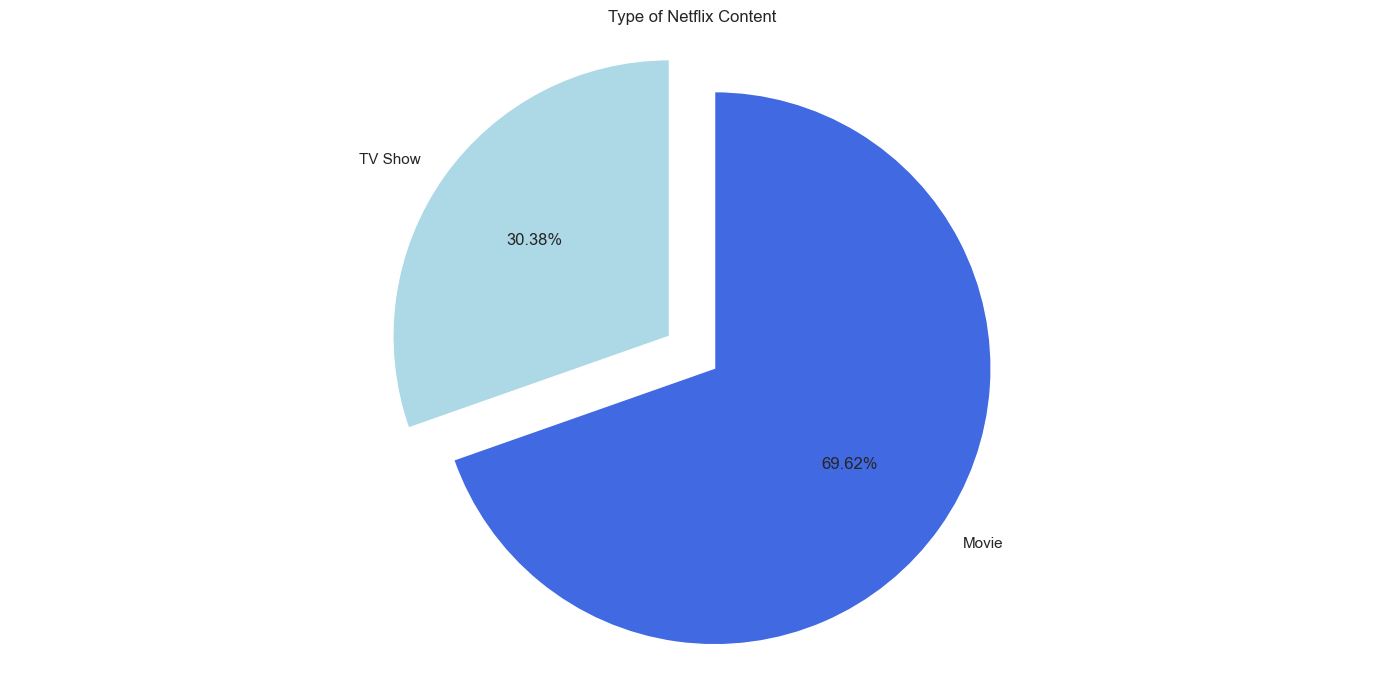

In [167]:
plt.figure(figsize=(14, 7))
labels=['TV Show', 'Movie']
print(df['type'].value_counts().sort_values())
plt.pie(df['type'].value_counts().sort_values()[-2:], labels=labels,explode=[0.1,0.1],
        autopct='%1.2f%%',colors=['lightblue','royalblue'], startangle=90)
plt.title('Type of Netflix Content')
plt.axis('equal')

plt.savefig("./chart_images/pie.png")
plt.show()

Les pays qui produisent le plus de films / series

In [187]:
country_count = df['country'].value_counts().head(10)
fig = px.bar(y=country_count.values, 
             x=country_count.index, 
            color = country_count.index,
            text=country_count.values,
             title= 'Top 10 des pays qui produisent des Film')

fig.write_image("./chart_images/top_10.png")

fig

La courbe des sorties des films sur Netflix

2018                1145
2017                1030
2019                1026
2020                 952
2016                 901
                    ... 
 Charles Rocket        1
January 15, 2021       1
1925                   1
 Jade Eshete           1
1959                   1
Name: release_year, Length: 94, dtype: int64


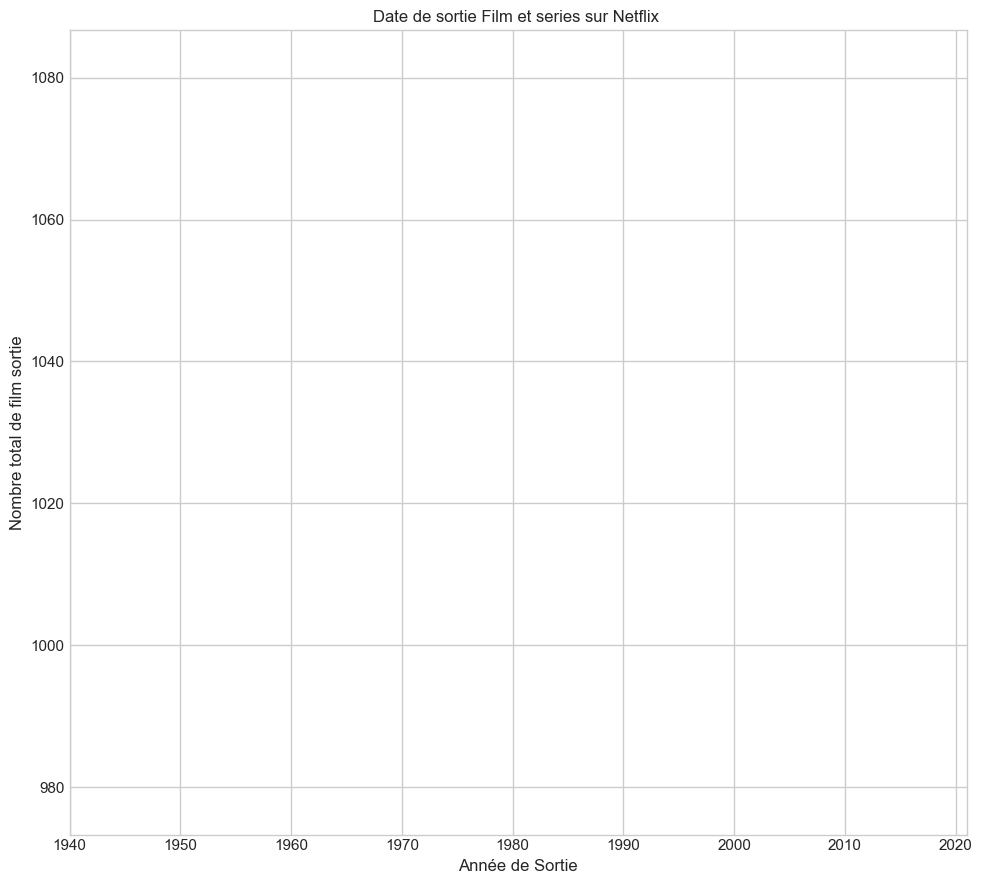

In [169]:
release_year_count=df.release_year.value_counts()
print(release_year_count)
# release_year_count=spark.createDataFrame(release_year_count).toPandas()
# release_year_count=release_year_count.copy(deep=True)

plt.figure(figsize=(10, 9))
# sns.set()
# sns.lineplot(data=release_year_count)
plt.plot(release_year_count[0], release_year_count[1])
plt.title('Date de sortie Film et series sur Netflix ')
plt.xlim(1940, 2021)
plt.xlabel('Année de Sortie')
plt.ylabel('Nombre total de film sortie')
plt.show()
# sns.plt.show()

Courbe de différents type de films 

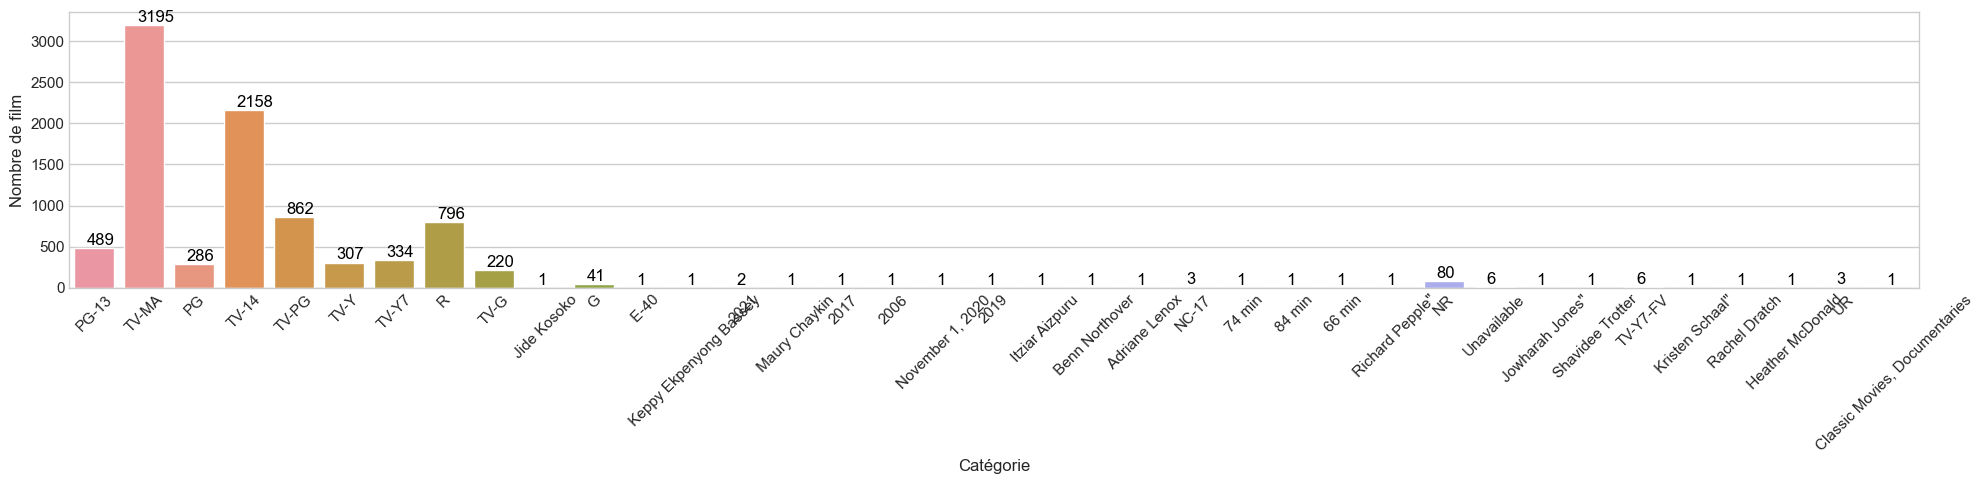

In [170]:
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-whitegrid')
ax = sns.countplot(x = 'rating', data = df)
plt.xlabel('Catégorie')
plt.ylabel('Nombre de film')
plt.xticks(rotation = 45)
for p in ax.patches:
    ax.annotate(int(p.get_height()), (p.get_x()+0.25, p.get_height()+1), va = 'bottom', color = 'black')
    
plt.savefig("./chart_images/cat.png")

Les Tops genre sur Netflix

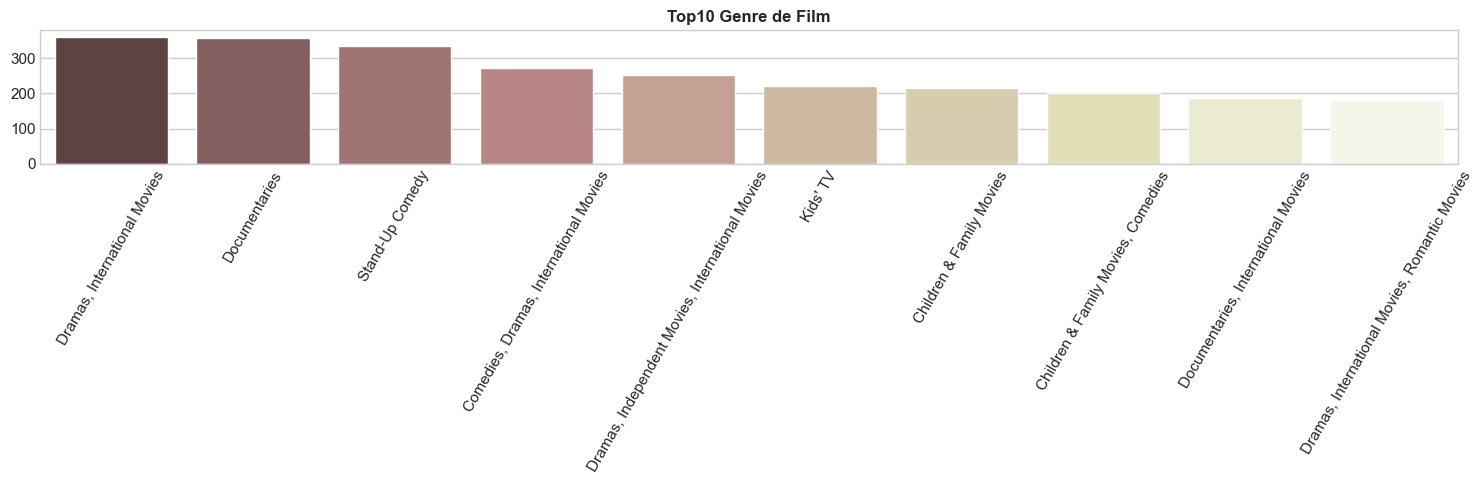

In [171]:
plt.figure(figsize=(15,5))
sns.barplot(x = df["listed_in"].value_counts().head(10).index,
            y = df["listed_in"].value_counts().head(10).values,palette="pink")
plt.xticks(rotation=60)
plt.title("Top10 Genre de Film",fontweight="bold")
plt.savefig("./chart_images/top_10_cat.png")
plt.show()

# Set plot parameters

In [172]:
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True

# choose columns to plot

In [173]:
class Column(Enum):
    TYPE = 'type'
    TITLE = 'title'
    DIRECTOR = 'director'
    CAST = 'cast'
    COUNTRY = 'country'
    DATE_ADDED = 'date_added'
    RELEASE_YEAR = 'release_year'
    RATING = 'rating'
    DURATION = 'duration'
    LISTED_IN = 'listed_in'
    DESCRIPTION = 'description'

columns = [Column.TYPE.value, Column.TITLE.value, Column.RELEASE_YEAR.value, Column.DURATION.value]

class Types(Enum):
  TV_SHOW = 'TV Show'
  MOVIE = 'Movie'

# reset data set

In [174]:
df = global_df.copy(deep=True)

# Plot data

In [175]:
print("Contents in csv file:", df)

Contents in csv file:      show_id     type                  title         director  \
0         s1    Movie   Dick Johnson Is Dead  Kirsten Johnson   
1         s2  TV Show          Blood & Water             None   
2         s3  TV Show              Ganglands  Julien Leclercq   
3         s4  TV Show  Jailbirds New Orleans             None   
4         s5  TV Show           Kota Factory             None   
...      ...      ...                    ...              ...   
8804   s8803    Movie                 Zodiac    David Fincher   
8805   s8804  TV Show            Zombie Dumb             None   
8806   s8805    Movie             Zombieland  Ruben Fleischer   
8807   s8806    Movie                   Zoom     Peter Hewitt   
8808   s8807    Movie                 Zubaan      Mozez Singh   

                                                   cast        country  \
0                                                  None  United States   
1     Ama Qamata, Khosi Ngema, Gail Mabalane, Tha

In [176]:
titles = df.title
durations = df.duration

## cleaning data

types

In [177]:
movies_df = df[df.type == Types.MOVIE.value]
tv_shows_df = df[df.type == Types.TV_SHOW.value]

durations

In [178]:
def clean_durations(durations: list) -> list: 
  cleaned_durations = []

  for duration in durations:
    try: 
      duration = int(duration.split(' ')[0])
    except:
      duration = 0
    cleaned_durations.append(duration)

  return cleaned_durations

In [179]:
movies_df.duration = clean_durations(movies_df.duration)
tv_shows_df.duration = clean_durations(tv_shows_df.duration)

In [180]:
print(tv_shows_df.duration.head(10))

1     2
2     1
3     1
4     2
5     1
8     9
10    1
11    1
14    1
15    4
Name: duration, dtype: int64


In [181]:
def clean_years(years: list) -> list: 
  cleaned_years = []

  for year in years:
    try: 
      year = year if year is int else int(year.split(', ')[-1])
    except:
      print(year)
      year = float('nan')
    cleaned_years.append(year)

  return cleaned_years

In [182]:
clean_years(movies_df.release_year)
movies_df.release_year = clean_years(movies_df.release_year)
tv_shows_df.release_year = clean_years(tv_shows_df.release_year)

 Paul Sambo
 Dr. Dre
 Charles Rocket
United States
 Álvaro Cervantes
 Imanol Arias
 Francis Weddey
 Peter Ferriero
 Marquell Manning
 Nick Kroll
 Ted Ferguson
 Kristen Johnston
None
 Paul Sambo
 Dr. Dre
 Charles Rocket
United States
 Álvaro Cervantes
 Imanol Arias
 Francis Weddey
 Peter Ferriero
 Marquell Manning
 Nick Kroll
 Ted Ferguson
 Kristen Johnston
None
 Nse Ikpe-Etim
 Jade Eshete


In [183]:
tv_shows_year_mean_df = tv_shows_df.drop([Column.TYPE.value, Column.TITLE.value], axis=1).copy(deep=True)
tv_shows_year_mean_df.set_index([Column.RELEASE_YEAR.value], inplace=True)
tv_shows_year_mean_df = tv_shows_year_mean_df.groupby(by=Column.RELEASE_YEAR.value).mean()

tv_shows_year_count_df = tv_shows_df.drop([Column.TYPE.value, Column.TITLE.value], axis=1).copy(deep=True)
tv_shows_year_count_df = tv_shows_year_count_df.groupby(by=Column.RELEASE_YEAR.value).count()

movies_year_mean_df = movies_df.drop([Column.TYPE.value, Column.TITLE.value], axis=1).copy(deep=True)
movies_year_mean_df.set_index([Column.RELEASE_YEAR.value], inplace=True)
movies_year_mean_df = movies_year_mean_df.groupby(by=Column.RELEASE_YEAR.value).mean()

movies_year_count_df = movies_df.drop([Column.TYPE.value, Column.TITLE.value], axis=1).copy(deep=True)
movies_year_count_df = movies_year_count_df.groupby(by=Column.RELEASE_YEAR.value).count()

print('done')

done


### Plot tv shows mean duration per year

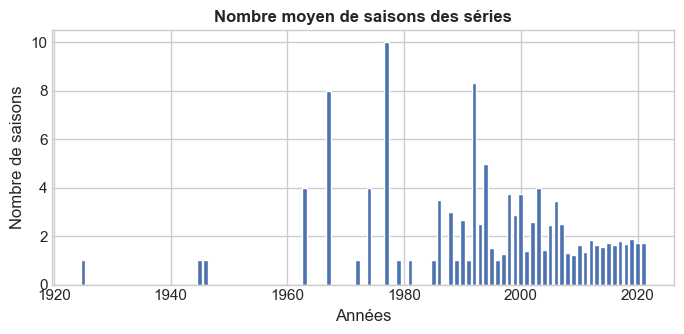

In [184]:
tv_shows_year_mean_df = tv_shows_year_mean_df.reset_index()
plt.bar(tv_shows_year_mean_df[Column.RELEASE_YEAR.value], tv_shows_year_mean_df[Column.DURATION.value], label='TV Shows')
plt.xlabel('Années')
plt.ylabel('Nombre de saisons')
plt.title("Nombre moyen de saisons des séries",fontweight="bold")
plt.savefig("./chart_images/tv_show_mean_duration.png")
plt.show()

### Plot movies mean durations per year

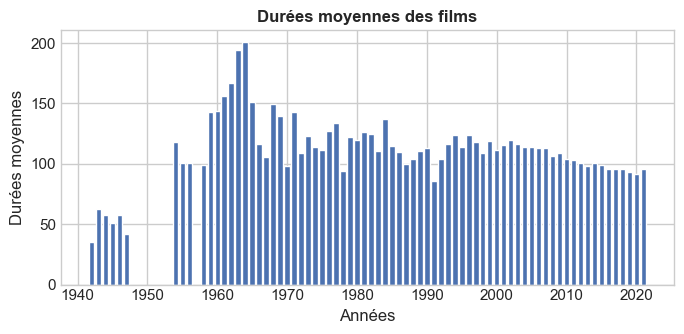

In [185]:
movies_year_mean_df = movies_year_mean_df.reset_index()
plt.bar(movies_year_mean_df.release_year, movies_year_mean_df.duration, label='Movies')
plt.xlabel('Années')
plt.ylabel('Durées moyennes')
plt.title('Durées moyennes des films', fontweight="bold")
plt.savefig("./chart_images/movie_mean_duration.png")
plt.show()

### Plot movies duration count per  year

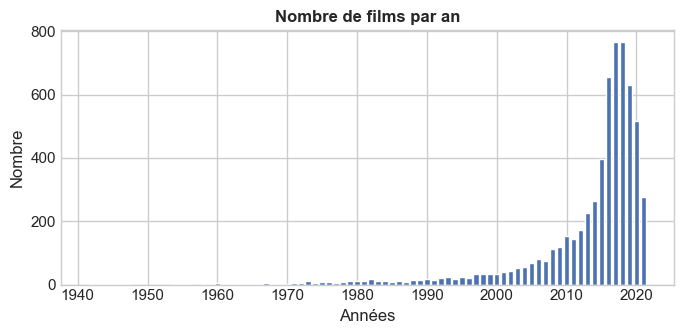

In [186]:
movies_year_count_df = movies_year_count_df.reset_index()
plt.bar(movies_year_count_df.release_year, movies_year_count_df.duration, label='Movies')
plt.xlabel('Années')
plt.ylabel('Nombre')
plt.title('Nombre de films par an', fontweight="bold")
plt.savefig("./chart_images/movie_count.png")
plt.show()